##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import keras

In [4]:
# Use Keras 2.
version_fn = getattr(keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

Import `matplotlib` and create a helper function to plot graphs:

In [5]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [6]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [7]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"This musical is decidedly mixed, and none of the elements really fit together, but it somehow manages to be mostly enjoyable. The plot contains some of the elements of Wodehouse's novel, but none of its virtues, though he co-wrote the script. The songs, though charming, have nothing to do with this particular film, and are unusually crudely squeezed into the plot, even by pre-Oklahoma standards. Burns and Allen do their usual shtick quite competently, but it misses the tone of the rest of the film by about forty IQ points.<br /><br />There are a few high points. Reginald Gardiner does good work when he remembers that this is a talkie, and stops mugging like a silent actor. And there are a few bits of writing which could only have been written by Wodehouse, though most of the film feels like the production of one of the Hollywood meetings he later parodied."
 b'The story for the first-aired television installment of "Columbo" is simple: one-half of successful mystery-writing 

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [11]:
VOCAB_SIZE = 1000
encoder = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [13]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11, 619,   7, ...,   0,   0,   0],
       [  2,  64,  16, ...,   0,   0,   0],
       [ 51,  10, 208, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [14]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This musical is decidedly mixed, and none of the elements really fit together, but it somehow manages to be mostly enjoyable. The plot contains some of the elements of Wodehouse's novel, but none of its virtues, though he co-wrote the script. The songs, though charming, have nothing to do with this particular film, and are unusually crudely squeezed into the plot, even by pre-Oklahoma standards. Burns and Allen do their usual shtick quite competently, but it misses the tone of the rest of the film by about forty IQ points.<br /><br />There are a few high points. Reginald Gardiner does good work when he remembers that this is a talkie, and stops mugging like a silent actor. And there are a few bits of writing which could only have been written by Wodehouse, though most of the film feels like the production of one of the Hollywood meetings he later parodied."
Round-trip:  this musical is [UNK] [UNK] and none of the elements really [UNK] together but it somehow manages to be 

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [15]:
model = keras.Sequential([
    encoder,
    keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [16]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [17]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Convert to numpy array and cast to object dtype
input_array = np.array([sample_text]).astype(object)

#predictions = model.predict(np.array([sample_text]))
predictions = model.predict(input_array)
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[-0.00460574]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [18]:
# predict on a sample text with padding

padding = "the " * 2000

# Convert to numpy array and cast to object dtype
input_array = np.array([sample_text,padding]).astype(object)

#predictions = model.predict(np.array([sample_text, padding]))
predictions = model.predict(input_array)
print(predictions[0])

1/1 [==============================] - 0s 85ms/step
[-0.00460574]


Compile the Keras model to configure the training process:

In [19]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#Calculating carbon emissions during model training

In [20]:
!pip install carbontracker
from carbontracker.tracker import CarbonTracker

## Train the model

In [21]:
#history = model.fit(train_dataset, epochs=10,   #Train one epoch at a time
#                    validation_data=test_dataset,
#                    validation_steps=30)

In [22]:
from carbontracker.tracker import CarbonTracker

#Initialize tracker
tracker = CarbonTracker(epochs=10)

#Store training history manually
history_dict = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

#Training loop (1 epoch per iteration)
for epoch in range(10):
    tracker.epoch_start()

    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        validation_steps=30,
        epochs=1,
        verbose=1
    )

    # Save metrics
    history_dict['loss'].append(history.history['loss'][0])
    history_dict['accuracy'].append(history.history['accuracy'][0])
    history_dict['val_loss'].append(history.history['val_loss'][0])
    history_dict['val_accuracy'].append(history.history['val_accuracy'][0])

    tracker.epoch_end()

#Print carbon emissions report
tracker.stop()


CarbonTracker: The following components were found: GPU with device(s) Tesla T4.
CarbonTracker: WARNING - ElectricityMaps API key not set. Will default to average carbon intensity.
CarbonTracker: WARNING - Failed to retrieve carbon intensity: Defaulting to average carbon intensity 369.47318 gCO2/kWh.
391/391 [==============================] - 56s 91ms/step - loss: 0.6498 - accuracy: 0.5576 - val_loss: 0.5163 - val_accuracy: 0.7328
CarbonTracker: WARNING - ElectricityMaps API key not set. Will default to average carbon intensity.
CarbonTracker: WARNING - Failed to retrieve carbon intensity: Defaulting to average carbon intensity 369.47318 gCO2/kWh.
CarbonTracker: Live carbon intensity could not be fetched at detected location: The Dalles, Oregon, US. Defaulted to average carbon intensity for US in 2023 of 369.47 gCO2/kWh. at detected location: The Dalles, Oregon, US.
CarbonTracker: 
Predicted consumption for 10 epoch(s):
	Time:	0:09:20
	Energy:	0.008972118453 kWh
	CO2eq:	3.314957136228 

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 52ms/step - loss: 0.3202 - accuracy: 0.8589
Test Loss: 0.3202466666698456
Test Accuracy: 0.8588799834251404


In [24]:
#plt.figure(figsize=(16, 8))
#plt.subplot(1, 2, 1)
#plot_graphs(history, 'accuracy')
#plt.ylim(None, 1)
#plt.subplot(1, 2, 2)
#plot_graphs(history, 'loss')
#plt.ylim(0, None)

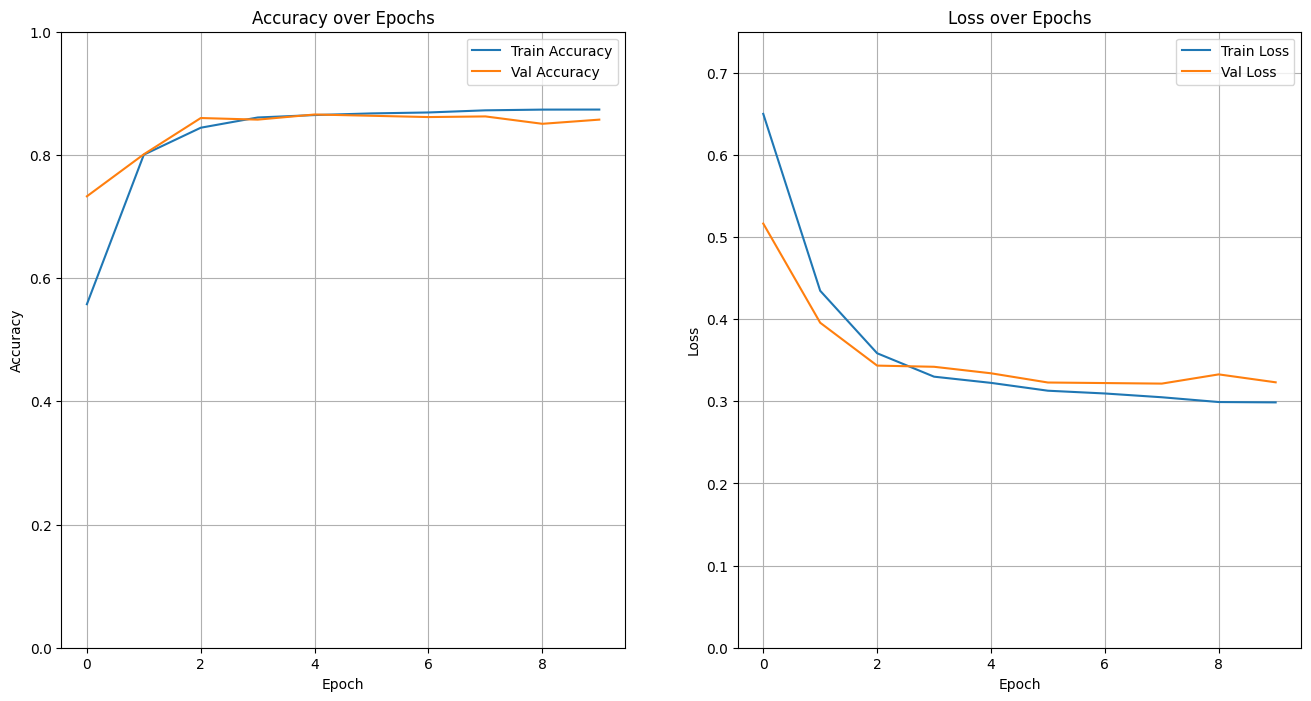

In [25]:
plt.figure(figsize=(16, 8))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.ylim(0, 1)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.ylim(0, max(history_dict['loss']) + 0.1)
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [26]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Convert to numpy array and cast to object dtype
input_array = np.array([sample_text]).astype(object)

#predictions = model.predict(np.array([sample_text]))
predictions = model.predict(input_array)
print(predictions[0])

1/1 [==============================] - 4s 4s/step
[1.2967036]
